# Parallel transport 
In this notebook, we illustrate the problem of parallel transport. We start with the trival case of flat space ($M = \mathbb{R}^2$), where we know that vectors do not change when they are being transported. However, to make it more interesting, we work with curvilinear coordinates, in particular, polar coordinates $r, \theta$. The code developed in this part can be straightforwardly applied for more general curved manifolds.

## Flat space with polar coordinates

Any vector that is parallel-transported along some trajectory with coordinates $x^\mu(t)$ can be written as $V^\mu(t)\partial_\mu$ (it is never a bad idea to keep in mind that the vectors $\partial_\mu$ actually depend on the point in the manifold). The components $V^\mu(t)$ must fulfill the equation of parallel transport:
\begin{equation*}
    \dot{V}^\mu + \Gamma^\mu_{\sigma\rho}\dot{x}^\sigma V^\rho = 0
\end{equation*}
which is actually a system of ordinary differential equations, with one equation for each component. In other words, the problem of parallel transport can be framed as an initial value problem, where the initial conditions are the components of the vector we want to transport, and we need to specify the trajectory that the vector is going to follow.

In flat space, the Christoffel coefficients of the Levi-Civita connection (the one that makes the most intuitive sense because is derived from the metric) are such that the vector itself remains the same. Thus, in Cartesian coordinates ($x, y$), the coefficients vanish: $\dot{V}^x = \dot{V}^y = 0\implies V^x = V^x(0), V^y = V^y(0)$. However, we need not choose to work with Cartesian coordinates nor the associated coordinate basis in $T_p M$ the tangent space at each point. If we choose curvilinear coordinates, such as $r, \theta$, and the corresponding basis in $T_p M$, namely $\partial_r, \partial_\theta$, the basis vectors will change throughout the trajectory. Hence, to keep the vector constant as it should be, the components must also change. The way in which they change is, of course, dictated by the equation of parallel transport.

Thus, we need the Christoffel coefficients:
\begin{equation*}
    \Gamma^\mu_{\sigma\rho} = \frac 12 g^{\mu\nu}\left(\partial_\sigma g_{\nu\rho} + \partial_\rho g_{\nu\mu} - \partial_\nu g_{\sigma\rho}\right)
\end{equation*}
For $\mathbb{R}^2$, with $r$ and $\theta$ as coordinates, calculating the Christoffel coefficients is relatively straightfoward knowing that $g = \mathrm{d}r\otimes\mathrm{d}r + r^2 \mathrm{d}\theta\otimes\mathrm{d}\theta$. However, we can use the library `einsteinpy` to obtain them symbolically, and with considerably less effort.

In [ ]:
# import the necessary libraries
import sympy as smp  # for symbolic manipulation capabilities
from einsteinpy.symbolic import MetricTensor, ChristoffelSymbols

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib widget

In [ ]:
# set coordinate system as smp.symbols
r, theta = smp.symbols("r theta")

# create metric
g_sym = smp.diag(1, r**2).tolist()
g = MetricTensor(g_sym, [r, theta])

# we can look at the metric components with the "tensor" method
g.tensor()

[[1, 0], [0, r**2]]

Once the metric is specified as an instance of the `MetricTensor` class, obtaining the Christoffel symbols from the metric with `einsteinpy` is as simple as the code in the following cell.

In [3]:
# Christoffel symbols
CS = ChristoffelSymbols.from_metric(g)

# again, the components can be displayed with the "tensor" method. Don't be fooled. The Christoffel symbols are not tensors!
CS.tensor()

[[[0, 0], [0, -r]], [[0, 1/r], [1/r, 0]]]

In [4]:
# and we can select components individually with 
CS.tensor()[0, 1, 1]
# where the first index is the upper one, and the last two are the lower ones (symmetric/torsion-free conection)

-r

The last thing we need to do our parallel transport simulation is to define a trajectory to follow. We are going to use `smp` to keep the manipulations symbolic for as long as we can.
### Trajectory 1

In [ ]:
# symbolic trajectory
t = smp.symbols("t")  # parameter
xs = [smp.sqrt(1 + t**2), smp.atan(t)]  # parametrized trajectory: r(t), theta(t)
# incidentally, this trajectory corresponds to a straight vertical line given by x = 1 in Cartesian coordinates.

vs = [smp.diff(x, t) for x in xs]  # velocity along the trajectory: r'(t), theta'(t)
# we have created vs with a so-called list comprehension. If you are not familiar with this kind 
# of constructions, they simply implement a loop and fill the list with the elements as the loop 
# goes

Finally, we have to set up the parallel transport equations:
\begin{align*}
    \dot{V}^r &= - \Gamma^r_{\sigma\rho}\dot{x}^\sigma V^\rho = - \Gamma^r_{rr}\dot{r}V^r - \Gamma^r_{r\theta} \left(\dot{r} V^\theta + \dot{\theta}V^r\right) - \Gamma^{r}_{\theta\theta} \dot{\theta} V^\theta = F^r\\
    \dot{V}^\theta &= - \Gamma^\theta_{\sigma\rho}\dot{x}^\sigma V^\rho = - \Gamma^\theta_{rr}\dot{r}V^r - \Gamma^\theta_{r\theta} \left(\dot{r} V^\theta + \dot{\theta}V^r\right) - \Gamma^{\theta}_{\theta\theta} \dot{\theta} V^\theta = F^\theta
\end{align*}
In the code cell below, we implement the left-hand sides, given by $F^r$ and $F^\theta$.

In [ ]:
# symbolic vector components
Vs = [smp.symbols("V^r"), smp.symbols("V^theta")]

# left-hand side of the parallel transport equations
Fs = [sum(
            -CS[i, j, k] * vj * Vk   
            for j, vj in enumerate(vs) for k, Vk in enumerate(Vs)
      ).subs([(r, xs[0]), (theta, xs[1])])
      for i, xi in enumerate(xs)]
# we have again used comprehensions.
# - the outer loop over xs (r and theta) makes Fs a list of two elements: Fr and Ftheta 
# - inside sum(), we perform the two sums due to the contracted indices sigma and rho: -Christoffel[i, j, k] * velocity[j] * Vector[k]
# - using .subs(), we replace the symbols r --> r(t) and theta --> theta(t)

After the dust settles, we can see what our left-hand sides are:

In [7]:
Fs[0]

V^theta/sqrt(t**2 + 1)

In [8]:
Fs[1]

-V^r/(t**2 + 1)**(3/2) - V^theta*t/(t**2 + 1)

Sometimes, these equations will be analytically solvable. For the innumerably larger amount of equations that cannot be solved analytically, we resort to numerical methods. To that end, we use the `lambdify` function, that turns symbolic arguments and expressions into regular functions of said arguments that we can evaluate numerically.

In [ ]:
# list of numerical functions: [F^r(t, V^r, V^theta), F^theta(t, V^r, V^theta)]
Fs_num = [smp.lambdify((t, Vs[0], Vs[1]), Fs[0]), smp.lambdify((t, Vs[0], Vs[1]), Fs[1])]  

# set up system of differential equations for odeint 
def dfdt(f, t):
    Vr, Vtheta = f
    return [
        Fs_num[0](t, Vr, Vtheta),
        Fs_num[1](t, Vr, Vtheta)
    ]

# time array and initial conditions
time = np.linspace(0, 20, 100)
initial_conditions = np.array([1, 0])  # V^r = 1, V^theta = 0

# solve differential equations
sol = odeint(dfdt, initial_conditions, time)
# rename solutions
Vr, Vtheta = sol[:, 0], sol[:, 1]

We can now see how the components of $V$ evolve as we move along the trajectory, as solved by the numerical integration of the parallel transport equations. 

In this simple scenario, we can also compare the numerical solution with the analytical one obtained by solving the equations in Cartesian coordinates ($V^x = 1$, $V^y = 0$) and transforming the solutions to polar coordinates:
\begin{align*}
    V^r &= \cos\left(\theta\right) V^x + \sin\left(\theta\right) V^y\\
    V^\theta &= \frac1r \left[-\sin\left(\theta\right) V^x + \cos\left(\theta\right) V^y\right]
\end{align*}
On the trajectory, given by
\begin{align*}
    r(t) &= \sqrt{1 + t^2}\\
    \theta(t) &= \arctan(t),
\end{align*}
we have
\begin{align*}
    V^r &= \cos\left(\theta(t)\right)\\
    V^\theta &= -\frac{\sin\left(\theta(t)\right)}{r(t)}
\end{align*}

Text(0.5, 0, 'time')

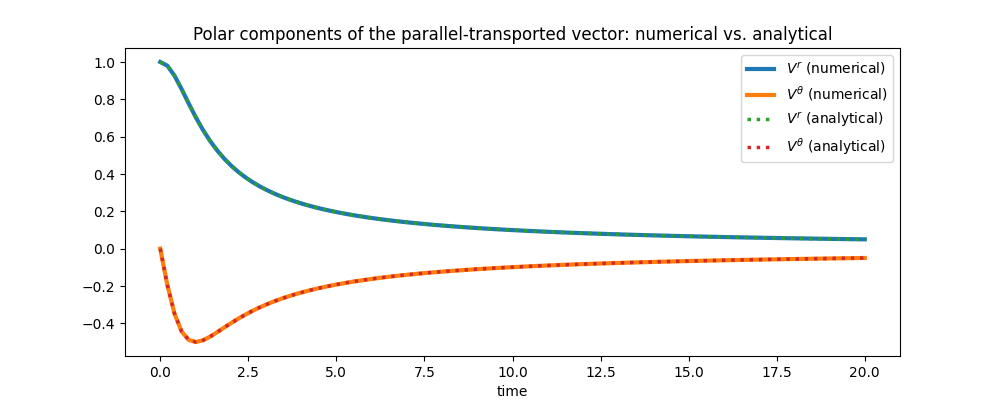

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# numerical solutions
axs.plot(time, Vr, lw=3, label=r"$V^r$ (numerical)")
axs.plot(time, Vtheta, lw=3, label=r"$V^\theta$ (numerical)")

# trajectory coordinates
r_t = np.sqrt(1 + time**2)
theta_t = np.atan(time)

# analytical solutions
axs.plot(time, np.cos(theta_t), lw=2.5, ls=":", label=r"$V^r$ (analytical)")
axs.plot(time, -np.sin(theta_t) / r_t, lw=2.5, ls=":", label=r"$V^\theta$ (analytical)")

axs.legend()
axs.set_title("Polar components of the parallel-transported vector: numerical vs. analytical")
plt.xlabel("time")

If we have done everything correctly, however, the vector itself should not change at all. We can see that this is the case by explicitly transforming everything into Cartesian coordinates:
\begin{align*} 
    V^x &= \frac{\partial x}{\partial r} V^r + \frac{\partial x}{\partial \theta} V^\theta = \cos\left(\theta\right) V^r - r\sin\left(\theta\right) V^\theta,\\
    V^y &= \frac{\partial y}{\partial r} V^r + \frac{\partial y}{\partial \theta} V^\theta = \sin\left(\theta\right) V^r + r\cos\left(\theta\right) V^\theta.
\end{align*}
Along the trajectory, we have:
\begin{align*} 
    V^x(t) &= \cos\left(\theta(t)\right) V^r(t) - r(t)\sin\left(\theta(t)\right) V^\theta(t),\\
    V^y(t) &= \sin\left(\theta(t)\right) V^r(t) + r(t)\cos\left(\theta(t)\right) V^\theta(t).
\end{align*}

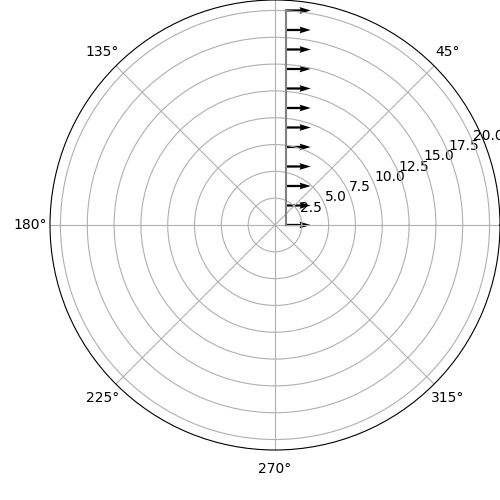

In [11]:
# Cartesian vector components
Vx = np.cos(theta_t) * Vr - r_t * np.sin(theta_t) * Vtheta
Vy = np.sin(theta_t) * Vr + r_t * np.cos(theta_t) * Vtheta

# polar coordinate plot of the parallel-transported vector
fig = plt.figure(figsize=(5, 5))
ax_polar = fig.add_axes(rect=[0.1, 0.1, 0.9, 0.9], projection="polar")
ax_polar.plot(theta_t, r_t, c="gray")  # trajectory
sl = slice(0, len(time), 9)  # slice object to choose how many arrows are shown
ax_polar.quiver(theta_t[sl], r_t[sl], Vx[sl], Vy[sl], width=.005)

### Trajectory 2
Another interesting example is the parallel transport of a vector along a circular trajectory:

In [ ]:
# symbolic trajectory
xs = [2, t]  # parametrized trajectory: r(t), theta(t)
vs = [smp.diff(x, t) for x in xs]  # velocity along the trajectory: r'(t), theta'(t)

# symbolic vector components
Vs = [smp.symbols("V^r"), smp.symbols("V^theta")]
# left-hand side of the parallel transport equations
Fs = [sum(
            -CS[i, j, k] * vj * Vk   
            for j, vj in enumerate(vs) for k, Vk in enumerate(Vs)
      ).subs([(r, xs[0]), (theta, xs[1])])
      for i, xi in enumerate(xs)]

# list of numerical functions: [F^r(t, V^r, V^theta), F^theta(t, V^r, V^theta)]
Fs_num = [smp.lambdify((t, Vs[0], Vs[1]), Fs[0]), smp.lambdify((t, Vs[0], Vs[1]), Fs[1])]  

# set up system of differential equations for odeint 
def dfdt(f, t):
    Vr, Vtheta = f
    return [
        Fs_num[0](t, Vr, Vtheta),
        Fs_num[1](t, Vr, Vtheta)
    ]

# time array and initial conditions
time = np.linspace(0, 2* np.pi, 100)
initial_conditions = np.array([1, 0])  # V^r = 1, V^theta = 0

# solve differential equations
sol = odeint(dfdt, initial_conditions, time)
# rename solutions
Vr, Vtheta = sol[:, 0], sol[:, 1]

Text(0.5, 0, 'time')

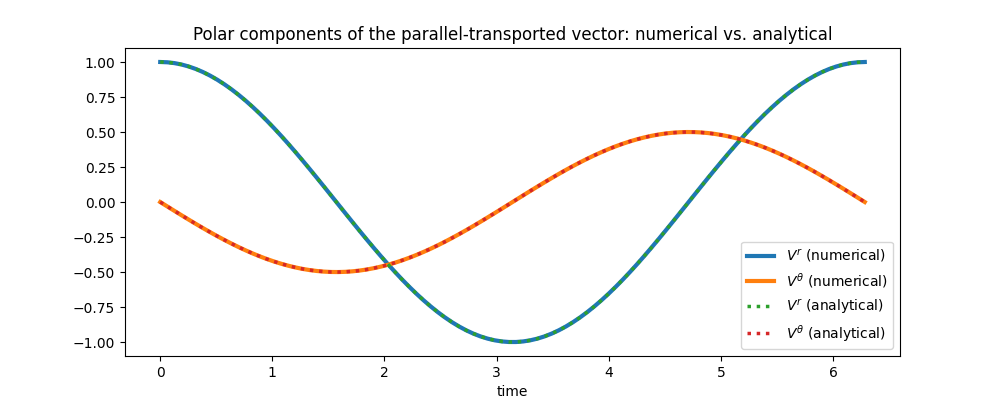

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# numerical solutions
axs.plot(time, Vr, lw=3, label=r"$V^r$ (numerical)")
axs.plot(time, Vtheta, lw=3, label=r"$V^\theta$ (numerical)")

# trajectory coordinates
r_t = np.ones_like(time)*2
theta_t = time

# analytical solutions
axs.plot(time, np.cos(theta_t), lw=2.5, ls=":", label=r"$V^r$ (analytical)")
axs.plot(time, -np.sin(theta_t) / r_t, lw=2.5, ls=":", label=r"$V^\theta$ (analytical)")

axs.legend()
axs.set_title("Polar components of the parallel-transported vector: numerical vs. analytical")
plt.xlabel("time")

(0.0, 2.5)

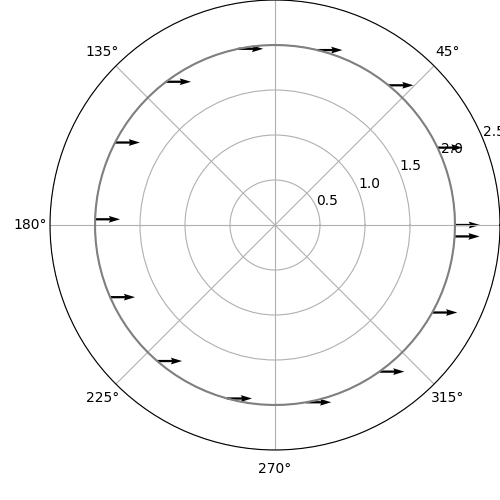

In [14]:
# Cartesian vector components
Vx = np.cos(theta_t) * Vr - r_t * np.sin(theta_t) * Vtheta
Vy = np.sin(theta_t) * Vr + r_t * np.cos(theta_t) * Vtheta

# polar coordinate plot of the parallel-transported vector
fig = plt.figure(figsize=(5, 5))
ax_polar = fig.add_axes(rect=[0.1, 0.1, 0.9, 0.9], projection="polar")
ax_polar.plot(theta_t, r_t, c="gray")  # trajectory
sl = slice(0, len(time), 7)  # slice object to choose how many arrows are shown
ax_polar.quiver(theta_t[sl], r_t[sl], Vx[sl], Vy[sl], width=.005)
ax_polar.set_rlim(0, 2.5)

## Sphere

We can repeat a similar analysis for a spherical surface.

In [ ]:
# symbolic coordinates
theta, phi = smp.symbols("theta phi")

# symbolic metric tensor
g_sym = smp.diag(1, smp.sin(theta)**2).tolist()
g = MetricTensor(g_sym, [theta, phi])
# g.tensor()

# Christoffel symbols
CS = ChristoffelSymbols.from_metric(g)
# CS.tensor()

# symbolic trajectory
t = smp.symbols("t")  # parameter
xs = [smp.pi / 2 + smp.cos(t) / 5, smp.sin(t)]  # parametrized trajectory: theta(t), phi(t)
vs = [smp.diff(x, t) for x in xs]  # velocity along the trajectory: r'(t), theta'(t)

# symbolic vector components
Vs = [smp.symbols("V^theta"), smp.symbols("V^phi")]

# left-hand side of the parallel transport equations
Fs = [sum(
            -CS[i, j, k] * vj * Vk   
            for j, vj in enumerate(vs) for k, Vk in enumerate(Vs)
      ).subs([(theta, xs[0]), (phi, xs[1])])
      for i, xi in enumerate(xs)]

In [16]:
Fs[0]

-V^phi*sin(cos(t)/5)*cos(t)*cos(cos(t)/5)

In [17]:
Fs[1]

-V^phi*sin(t)*sin(cos(t)/5)/(5*cos(cos(t)/5)) + V^theta*sin(cos(t)/5)*cos(t)/cos(cos(t)/5)

In [ ]:
# list of numerical functions: [F^r(t, V^r, V^theta), F^theta(t, V^r, V^theta)]
Fs_num = [smp.lambdify((t, Vs[0], Vs[1]), Fs[0]), smp.lambdify((t, Vs[0], Vs[1]), Fs[1])]  

# set up system of differential equations for odeint 
def dfdt(f, t):
    Vtheta, Vphi = f
    return [
        Fs_num[0](t, Vtheta, Vphi),
        Fs_num[1](t, Vtheta, Vphi)
    ]

# time array and initial conditions
time = np.linspace(0, 2*np.pi, 101)
initial_conditions = np.array([1, 0])  # V^theta = 1, V^phi = 0

# solve differential equations
sol = odeint(dfdt, initial_conditions, time)
# rename solutions
Vtheta, Vphi = sol[:, 0], sol[:, 1]

Text(0.5, 0, 'time (one full turn!)')

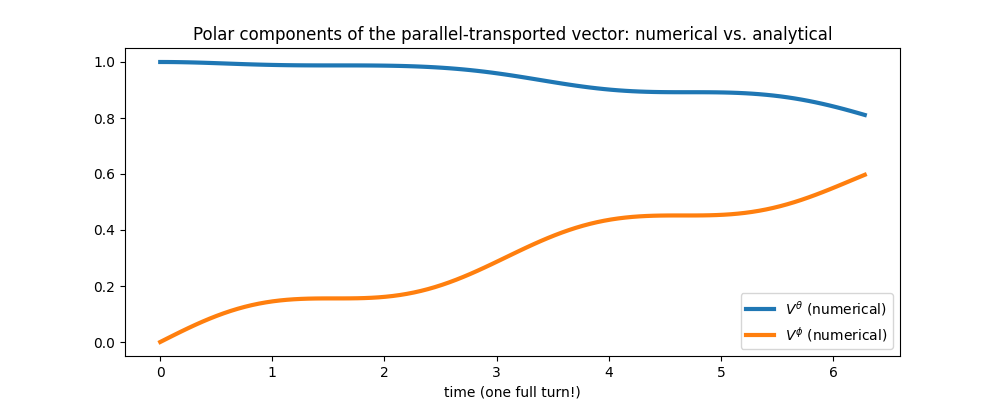

In [19]:
# plot evolution of vector components in spherical coordinates
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# numerical solutions
axs.plot(time, Vtheta, lw=3, label=r"$V^\theta$ (numerical)")
axs.plot(time, Vphi, lw=3, label=r"$V^\phi$ (numerical)")

axs.legend()
axs.set_title("Polar components of the parallel-transported vector: numerical vs. analytical")
plt.xlabel("time (one full turn!)")

The 2D plot above already shows that, after a full turn through the closed loop that the trajectory defines, the vector's components have changed and do not return to their previous value.

We can plot it in 3D

(-1.0, 1.0)

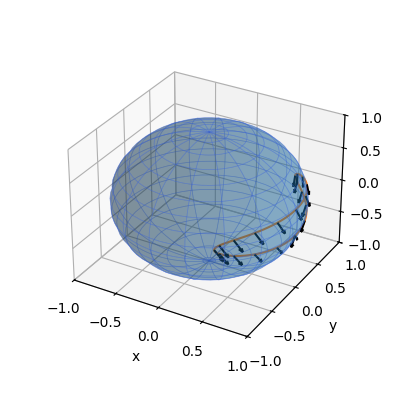

In [20]:
# trajectory in spherical coordinates
theta_t = np.pi/2 + np.cos(time)/5
phi_t = np.sin(time)

# trajectory in cartesian coordinates
x_t = np.sin(theta_t) * np.cos(phi_t)
y_t = np.sin(theta_t) * np.sin(phi_t)
z_t = np.cos(theta_t)

# surface coordinates
theta_s = (np.linspace(0, np.pi, 50)).reshape(-1, 1)
phi_s = (np.linspace(0, 2*np.pi, 50)).reshape(1, -1)
x_s = np.sin(theta_s) * np.cos(phi_s)
y_s = np.sin(theta_s) * np.sin(phi_s)
z_s = np.cos(theta_s) 

# plots
fig, axs = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(4, 4))

# plot surface
axs.plot_surface(x_s, y_s, z_s, alpha=0.3, edgecolor='royalblue', lw=0.5, rstride=3, cstride=3)

# plot trajectory
axs.plot(x_t, y_t, z_t)

# Cartesian components of the vector
Vx = np.cos(theta_t) * np.cos(phi_t) * Vtheta - np.sin(theta_t) * np.sin(phi_t) * Vphi
Vy = np.cos(theta_t) * np.sin(phi_t) * Vtheta + np.sin(theta_t) * np.cos(phi_t) * Vphi
Vz = -np.sin(theta_t) * Vtheta 

# plot transported vector
sl = slice(0, len(time), 5)
axs.quiver(x_t[sl], y_t[sl], z_t[sl], Vx[sl], Vy[sl], Vz[sl], length=0.2, color="k")

axs.set_xlabel("x")
axs.set_ylabel("y")
axs.set_xlim(-1, 1)
axs.set_ylim(-1, 1)
axs.set_zlim(-1, 1)
